In [14]:
import pandas as pd
import sklearn
import plotly.graph_objs as go

In [15]:
hol = pd.read_csv('adult_original_holdout.csv.gz')
trn = pd.read_csv('adult_original_2k.csv.gz')
syn = pd.read_csv('adult_synthetic.csv.gz')
syn_trn = pd.read_csv('adult_synthetic.csv.gz') # FIXME
syn_gen = pd.read_csv('adult_synthetic.csv.gz') # FIXME

### ML Performance

In [16]:
# benchmark GBM for `trn` vs `syn`, evaluated on `hol`

### Descriptive Statistics

#### relationship ~ sex

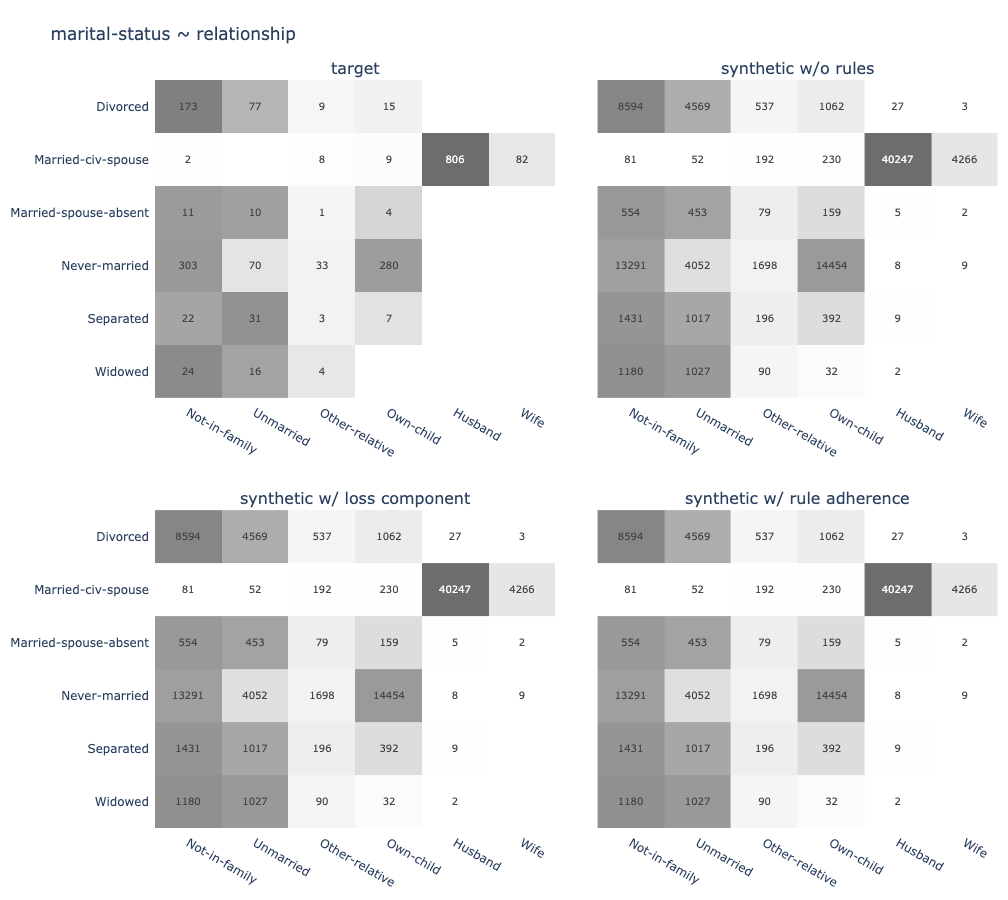

In [5]:
layout = go.Layout(
    title='marital-status ~ relationship',
    plot_bgcolor="rgba(0,0,0,0)",
    autosize=False,
    height=900,
    width=1100,
    margin=dict(l=10, r=10, b=10, t=80, pad=5),
    showlegend=False,
)
fig = go.Figure(layout=layout).set_subplots(
    rows=2,
    cols=2,
    horizontal_spacing=0.05,
    vertical_spacing=0.15,
    shared_yaxes=True,
    shared_xaxes=True,
    subplot_titles=("target", 
                    "synthetic w/o rules", 
                    "synthetic w/ loss component", 
                    "synthetic w/ rule adherence"),
)

def heat(data):
    col1 = 'marital-status'
    col2 = 'relationship'
    df = data[[col1, col2]].value_counts().to_frame('cnt').reset_index().sort_values([col1, 'cnt'], ascending=False)
    df["share_by_row"] = df["cnt"] / df.groupby(col1)["cnt"].transform("sum")
    heat = go.Heatmap(
        x=df[col2],
        y=df[col1],
        z=df["share_by_row"],
        text=df["cnt"],
        texttemplate="%{text}",
        textfont={"size": 10},
        zmin=0,
        zmax=1,
        colorscale=["white", "#A7A7A7", "#7B7B7B", "#666666"],
        showscale=False,
    )
    return heat

fig.add_trace(heat(tgt), row=1, col=1)
fig.add_trace(heat(syn), row=1, col=2)
fig.add_trace(heat(syn_trn), row=2, col=1)
fig.add_trace(heat(syn_gen), row=2, col=2)
fig.update_xaxes(tickangle=30, showticklabels = True, type = 'category')
fig.write_image("adult_relationship.png")
fig

### education ~ education.num

In [6]:
edu = tgt[['education', 'education-num']].drop_duplicates().sort_values('education-num')
edu['sort_idx'] = edu['education-num']

tgt["education-num"] = pd.Categorical(tgt["education-num"], categories=edu["education-num"], ordered=True)
syn["education-num"] = pd.Categorical(syn["education-num"], categories=edu["education-num"], ordered=True)
syn_trn["education-num"] = pd.Categorical(syn_trn["education-num"], categories=edu["education-num"], ordered=True)
syn_gen["education-num"] = pd.Categorical(syn_gen["education-num"], categories=edu["education-num"], ordered=True)

tgt["education"] = pd.Categorical(tgt.education, categories=edu.education, ordered=True)
syn["education"] = pd.Categorical(syn.education, categories=edu.education, ordered=True)
syn_trn["education"] = pd.Categorical(syn_trn.education, categories=edu.education, ordered=True)
syn_gen["education"] = pd.Categorical(syn_gen.education, categories=edu.education, ordered=True)

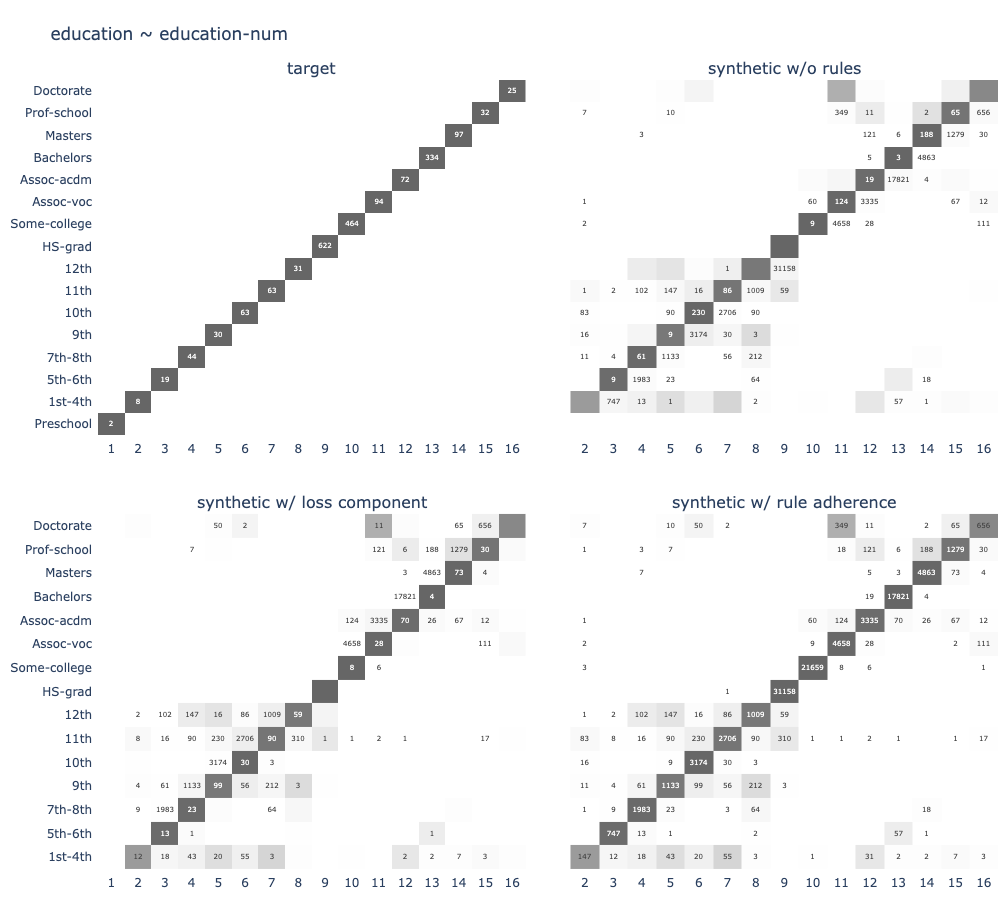

In [7]:
layout = go.Layout(
    title='education ~ education-num',
    plot_bgcolor="rgba(0,0,0,0)",
    autosize=False,
    height=900,
    width=1100,
    margin=dict(l=10, r=10, b=10, t=80, pad=5),
    showlegend=False,
)
fig = go.Figure(layout=layout).set_subplots(
    rows=2,
    cols=2,
    horizontal_spacing=0.05,
    vertical_spacing=0.10,
    shared_yaxes=True,
    shared_xaxes=True,
    subplot_titles=("target", 
                    "synthetic w/o rules", 
                    "synthetic w/ loss component", 
                    "synthetic w/ rule adherence"),
)

def heat(data):
    df = data[['education', 'education-num']].value_counts().to_frame('cnt').reset_index()
    df = pd.merge(df, edu, how='left', on=['education', 'education-num']).fillna(1000).sort_values('sort_idx')
    df["share_by_row"] = df["cnt"] / df.groupby("education")["cnt"].transform("sum")
    df["text"] = (df[["share_by_row"]] * 100).round(1)
    heat = go.Heatmap(
        x=df["education-num"],
        y=df["education"],
        z=df["share_by_row"],
        text=df["cnt"],
        texttemplate="%{text}",
        textfont={"size": 7},
        zmin=0,
        zmax=1,
        colorscale=["white", "#A7A7A7", "#7B7B7B", "#666666"],
        showscale=False,
    )
    return heat

fig.add_trace(heat(tgt), row=1, col=1)
fig.add_trace(heat(syn), row=1, col=2)
fig.add_trace(heat(syn_trn), row=2, col=1)
fig.add_trace(heat(syn_gen), row=2, col=2)
fig.update_xaxes(tickangle=0, showticklabels = True, type = 'category')
fig.write_image("adult_education.png")
fig

In [13]:
trn

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,23,Private,156513,HS-grad,9,Never-married,Handlers-cleaners,Own-child,Black,Male,0,0,40,United-States,<=50K
1,22,Private,242138,HS-grad,9,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,40,United-States,<=50K
2,32,Local-gov,32587,HS-grad,9,Divorced,Other-service,Not-in-family,Amer-Indian-Eskimo,Male,0,0,40,United-States,<=50K
3,22,Private,83315,HS-grad,9,Never-married,Adm-clerical,Unmarried,White,Male,0,0,40,United-States,<=50K
4,46,Private,142719,HS-grad,9,Married-spouse-absent,Farming-fishing,Not-in-family,White,Male,0,0,65,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,50,Private,94081,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
1996,47,Private,34248,HS-grad,9,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,38,United-States,<=50K
1997,35,Private,185084,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,48,United-States,>50K
1998,46,Self-emp-inc,216414,Masters,14,Married-civ-spouse,Sales,Husband,White,Male,0,1977,60,United-States,>50K


In [ ]:
# TODO: benchmark AUC for `income`, once trained on target and once on synthetic, evaluated on holdout
